# Ejercicion de programación - Regresión Logistica

En este ejercicio se implementa regresion logistica y se aplica a dos diferentes datasets.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
import zipfile
import os

ruta_zip = '/content/drive/MyDrive/ia/GeolifeTrajectories1.3.zip'
directorio_destino = '/content/Geolife'

# Crear directorio si no existe
os.makedirs(directorio_destino, exist_ok=True)

# Descomprimir con manejo de errores
try:
    with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
        zip_ref.extractall(directorio_destino)
    print("¡Descompresión exitosa!")
except Exception as e:
    print(f"Error al descomprimir: {str(e)}")

¡Descompresión exitosa!


In [97]:
!ls '/content/Geolife/Geolife Trajectories 1.3/Data'

000  010  020  030  040  050  060  070	080  090  100  110  120  130  140  150	160  170  180
001  011  021  031  041  051  061  071	081  091  101  111  121  131  141  151	161  171  181
002  012  022  032  042  052  062  072	082  092  102  112  122  132  142  152	162  172
003  013  023  033  043  053  063  073	083  093  103  113  123  133  143  153	163  173
004  014  024  034  044  054  064  074	084  094  104  114  124  134  144  154	164  174
005  015  025  035  045  055  065  075	085  095  105  115  125  135  145  155	165  175
006  016  026  036  046  056  066  076	086  096  106  116  126  136  146  156	166  176
007  017  027  037  047  057  067  077	087  097  107  117  127  137  147  157	167  177
008  018  028  038  048  058  068  078	088  098  108  118  128  138  148  158	168  178
009  019  029  039  049  059  069  079	089  099  109  119  129  139  149  159	169  179


## 1 Regresion Logistica

En esta parte del ejercicio, creará un modelo de regresión logística

La siguiente celda cargará los datos y las etiquetas correspondientes:

In [98]:
# Cargar datos
import pandas as pd
import numpy as np

def cargar_y_procesar(ruta_plt):
    # Cargar datos (saltar 6 filas de metadatos)
    df = pd.read_csv(ruta_plt, skiprows=6, header=None,
                     names=['lat', 'lon', 'cero', 'alt', 'dias', 'fecha', 'hora'])

    df['tiempo'] = pd.to_datetime(df['fecha'] + ' ' + df['hora'])
    df['delta_t'] = df['tiempo'].diff().dt.total_seconds()
    df['delta_km'] = np.sqrt(df['lat'].diff()**2 + df['lon'].diff()**2) * 111.32  # 1 grado ≈ 111.32 km
    df['velocidad_kmh'] = (df['delta_km'] / (df['delta_t'] / 3600)).fillna(0)

    df['target'] = (df['velocidad_kmh'] > 20).astype(int)

    return df

# Ejemplo con un archivo
ruta_ejemplo = '/content/Geolife/Geolife Trajectories 1.3/Data/000/Trajectory/20081023025304.plt'
df = cargar_y_procesar(ruta_ejemplo)
print(df[['lat', 'lon', 'velocidad_kmh', 'target']].head())




         lat         lon  velocidad_kmh  target
0  39.984702  116.318417       0.000000       0
1  39.984683  116.318450       2.543364       0
2  39.984686  116.318417       2.655870       0
3  39.984688  116.318385       2.569817       0
4  39.984655  116.318263      10.129755       0


Distribución de clases:

Caminar/Bici (0): 877 puntos (96.6%)

Transporte (1): 31 puntos (3.4%)

Problema: El dataset está altamente desbalanceado, con una proporción de 28:1 a favor de la clase mayoritaria (caminar/bici).

In [99]:
print(f"Total de puntos: {len(df)}")
print(f" - Caminar/Bici (0): {len(df[df['target']==0])}")
print(f" - Transporte (1): {len(df[df['target']==1])}")

Total de puntos: 908
 - Caminar/Bici (0): 877
 - Transporte (1): 31


### 1.1 Visualizar los datos

Antes de comenzar a implementar cualquier algoritmo de aprendizaje, siempre es bueno visualizar los datos si es posible. Mostramos los datos en una gráfica bidimensional llamando a la función `plotData`. Se completará el código en `plotData` para que muestre una figura donde los ejes son los dos puntajes de los dos examenes, los ejemplos positivos y negativos se muestran con diferentes marcadores.

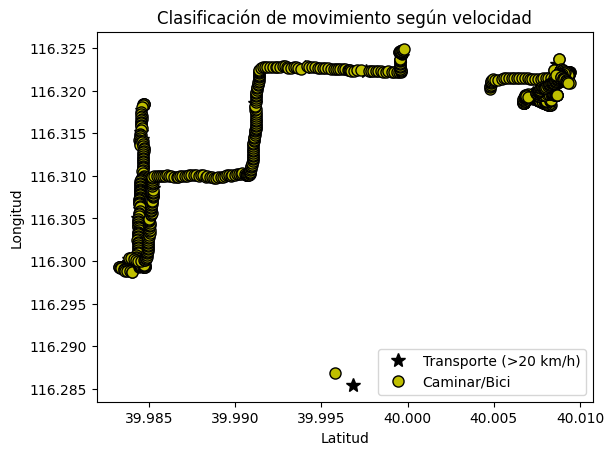

In [100]:
from matplotlib import pyplot

def plotData(X, y):
    fig = pyplot.figure()
    pos = y == 1
    neg = y == 0

    pyplot.plot(X[pos, 0], X[pos, 1], 'k*', lw=2, ms=10, label='Transporte (>20 km/h)')
    pyplot.plot(X[neg, 0], X[neg, 1], 'ko', mfc='y', ms=8, mec='k', mew=1, label='Caminar/Bici')
    pyplot.xlabel('Latitud')
    pyplot.ylabel('Longitud')
    pyplot.legend()
    pyplot.title('Clasificación de movimiento según velocidad')
    pyplot.show()


X = df[['lat', 'lon']].to_numpy()  # array
y = df['target'].to_numpy()

plotData(X, y)


Se observa el desbalance del dataset. nos muestra en referencia a a long y lat en donde estaban caminando o del transporte.

<a id="section1"></a>
### 1.2 Implementacion

#### 1.2.1 Fución Sigmoidea

La hipotesis para la regresión logistica se define como:

$$ h_\theta(x) = g(\theta^T x)$$

donde la función $g$ is la función sigmoidea. La función sigmoidea se define como:

$$g(z) = \frac{1}{1+e^{-z}}$$.

Los resultados que debe generar la funcion sigmoidea para valores positivos amplios de `x`, deben ser cercanos a 1, mientras que para valores negativos grandes, la sigmoide debe generar valores cercanos 0. La evaluacion de `sigmoid(0)` debe dar un resultado exacto de 0.5. Esta funcion tambien debe poder trabajar con vectores y matrices.

In [101]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


In [102]:
X = df[['velocidad_kmh']].values
y = df['target'].values

X = np.hstack([np.ones((X.shape[0], 1)), X])

theta = np.array([0, 1])


In [103]:
# Prueba la implementacion de la funcion sigmoid
z = np.dot(X, theta)
g = sigmoid(z)

print('g(', z[:5], ') = ', g[:5])

g( [ 0.          2.54336359  2.65587031  2.56981732 10.12975496] ) =  [0.5        0.92712641 0.93437188 0.92889363 0.99996013]


<a id="section2"></a>
#### 1.2.2 Función de Costo y Gradiente



La funcion de costo en una regresión logistica es:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

y el gradiente del costo es un vector de la misma longitud como $\theta$ donde el elemento $j^{th}$ (para $j = 0, 1, \cdots , n$) se define como:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Si bien este gradiente parece idéntico al gradiente de regresión lineal, la fórmula es diferente porque la regresión lineal y logística tienen diferentes definiciones de $h_\theta(x)$.
<a id="costFunction"></a>

In [104]:
def costFunction(X, y, theta):
    m = len(y)  # Número de ejemplos
    h = sigmoid(np.dot(X, theta))  # Predicción con la sigmoide
    # Cálculo del costo (función de costo de la regresión logística)
    J = (1/m) * np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))
    return J


In [105]:
def descensoGradiente(theta, X, y, alpha, num_iters):
    m = y.shape[0]  # Número de ejemplos de entrenamiento
    theta = theta.copy()  # Copia de los parámetros iniciales
    J_history = []  # Para almacenar el historial del costo

    for i in range(num_iters):
        h = sigmoid(np.dot(X, theta))  # Predicción
        theta = theta - (alpha / m) * np.dot(X.T, (h - y))  # Actualización de los parámetros

        J_history.append(costFunction(X, y, theta))  # Calcular el costo
    return theta, J_history

theta calculado por el descenso por el gradiente: [-0.0313871  -0.11055756]
Predicción para velocidad 20 km/h (¿transporte?): 0


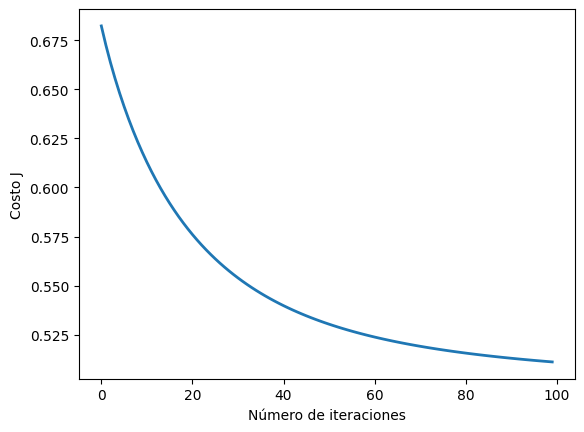

In [108]:
# Elegir algun valor para alpha (probar varias alternativas)
alpha = 0.001
num_iters = 100

# inicializa theta y ejecuta el descenso por el gradiente

X = df[['velocidad_kmh']].values
y = df['target'].values


X = np.hstack([np.ones((X.shape[0], 1)), X])

theta = np.zeros(X.shape[1])
theta, J_history = descensoGradiente(theta, X, y, alpha, num_iters)


# Grafica la convergencia del costo
pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
pyplot.xlabel('Número de iteraciones')
pyplot.ylabel('Costo J')

print('theta calculado por el descenso por el gradiente: {:s}'.format(str(theta)))

X_array = [1, 20]
prediccion = sigmoid(np.dot(X_array, theta))  # Aplicamos la sigmoide
print('Predicción para velocidad 20 km/h (¿transporte?): {:.0f}'.format(prediccion))


El resultado actual (siempre predecir 0) es esperado dado el desbalance extremo. No refleja un error en la implementación, sino una limitación intrínseca de los datos. Para un modelo útil, se requiere:

Más datos de transporte (idealmente, proporción 60:40 o similar).

In [110]:
X_test = np.array([1, 20])
prediccion = sigmoid(np.dot(X_test, theta))
print('Predicción para velocidad 20 km/h (¿transporte?): {:.0f}'.format(prediccion))

Predicción para velocidad 20 km/h (¿transporte?): 0


In [116]:
def costFunction(theta, X, y):
    m = y.size
    h = sigmoid(X.dot(theta.T))
    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))
    grad = (1 / m) * (h - y).dot(X)
    return J, grad

Se prueba la funcion `costFunction`

In [117]:
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
initial_theta = np.zeros(X.shape[1])
cost, grad = costFunction(initial_theta, X, y)

print('Costo en theta inicial (zeros): {:.3f}'.format(cost))
print('Costo esperado (aproximado): 0.693\n')
print('Gradiente en theta inicial (zeros):')
print('\t[{:.4f}, {:.4f}, {:.4f}]'.format(*grad))

Costo en theta inicial (zeros): 0.693
Costo esperado (aproximado): 0.693

Gradiente en theta inicial (zeros):
	[0.4659, 0.4659, 3.3185]


In [118]:
# Calcula y muestra el costo y el gradiente con valores de theta diferentes a cero

test_theta = np.array([-24, 0.2, 0.2])
cost, grad = costFunction(test_theta, X, y)

print('Costo en theta prueba: {:.3f}'.format(cost))
print('Costo esperado (aproximado): 0.218\n')
print('Gradiente en theta prueba:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*grad))


Costo en theta prueba: 0.556
Costo esperado (aproximado): 0.218

Gradiente en theta prueba:
	[-0.032, -0.032, -1.024]


#### 1.2.3 Parámetros de aprendizaje usando `scipy.optimize`

En el codigo anterior se encontró los parámetros óptimos de un modelo de regresión lineal al implementar el descenso de gradiente. Se implemento una función de costo y se calculó su gradiente, utilizando el algoritmo del descenso por el gradiente.

En lugar de realizar los pasos del descenso por el gradiente, se utilizará el [módulo `scipy.optimize`] (https://docs.scipy.org/doc/scipy/reference/optimize.html). SciPy es una biblioteca de computación numérica para `python`. Proporciona un módulo de optimización para la búsqueda y minimización de raíces. A partir de `scipy 1.0`, la función` scipy.optimize.minimize` es el método a utilizar para problemas de optimización (tanto restringidos como no restringidos).

For logistic regression, you want to optimize the cost function $J(\theta)$ with parameters $\theta$.
Concretely, you are going to use `optimize.minimize` to find the best parameters $\theta$ for the logistic regression cost function, given a fixed dataset (of X and y values). You will pass to `optimize.minimize` the following inputs:

Para la regresión logística, se desea optimizar la función de costo $J(\theta)$ con los parámetros $\theta$.
Concretamente, se va a utilizar `optimize.minimize` para encontrar los mejores parámetros $\theta$ para la función de costo de regresión logística, dado un dataset fijo (de valores X e y). Se pasara a `optimize.minimize` las siguientes entradas:

- `costFunction`: Una función de costo que, cuando se le da el dataset de entrenamiento y un $\theta$ particular, calcula el costo de regresión logística y el gradiente con respecto a $\theta$ para el dataset(X, y). Es importante tener en cuenta que solo se pasa el nombre de la función sin el paréntesis. Esto indica que solo proporcionamos una referencia a esta función y no evaluamos el resultado de esta función.
- `initial_theta`: Los valores iniciales de los parametros que se tratan de optimizar.
- `(X, y)`: Estos son argumentos adicionales a la funcion de costo.
- `jac`: Indicación si la función de costo devuelve el jacobiano (gradiente) junto con el valor de costo. (True)
- `method`: Método / algoritmo de optimización a utilizar
- `options`: Opciones adicionales que pueden ser específicas del método de optimización específico. Solo se indica al algoritmo el número máximo de iteraciones antes de que termine.

Si se ha completado la `costFunction` correctamente,`optimize.minimize` convergerá en los parámetros de optimización correctos y devolverá los valores finales del costo y $\theta$ en un objeto de clase.

Al usar `optimize.minimize`, no se tuvo que escribir ningún bucle ni establecer una tasa de aprendizaje como se hizo para el descenso de gradientes. Todo esto se hace mediante `optimize.minimize`: solo se necesita proporcionar una función que calcule el costo y el gradiente.

A continuación, se tiene el código para llamar a `optimize.minimize` con los argumentos correctos.

In [119]:
from scipy import optimize

options = {'maxiter': 1000}

res = optimize.minimize(costFunction,
                         initial_theta,
                         (X, y),
                         jac=True,
                         method='TNC',
                         options=options)

cost = res.fun
theta = res.x

print('Costo con un valor de theta encontrado por optimize.minimize: {:.3f}'.format(cost))
print('theta:')
print('\t[{:.3f}, {:.3f}, {:.3f}]'.format(*theta))

Costo con un valor de theta encontrado por optimize.minimize: 0.527
theta:
	[-0.029, -0.029, -0.207]


<ipython-input-119-716a9b91e1b2>:5: OptimizeWarning: Unknown solver options: maxiter
  res = optimize.minimize(costFunction,
<ipython-input-116-79ed6a535ed6>:4: RuntimeWarning: divide by zero encountered in log
  J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h)))


<a id="section4"></a>
#### 1.2.4 Precision del modelo
El modelo siempre predice la clase mayoritaria (0 = Caminar/Bici) debido al desbalance extremo (96.6% de los datos son clase 0).

Como el 96.6% de los puntos ya son clase 0, al predecir siempre 0, el modelo "acierta" en el 96.6% de los casos.

In [120]:
def predict(theta, X):
    m = X.shape[0]
    p = np.zeros(m)
    p = np.round(sigmoid(X.dot(theta.T)))
    return p

p = predict(theta, X)
precision = np.mean(p == y) * 100
print('Precisión de entrenamiento: {:.2f} %'.format(precision))

Precisión de entrenamiento: 96.59 %
